In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import LabelPowerset

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Data Preprocessing</h3>

In [2]:
df = pd.read_csv('./WineQT.csv')

In [3]:
print(np.mean(df,axis=0))

fixed acidity             8.311111
volatile acidity          0.531339
citric acid               0.268364
residual sugar            2.532152
chlorides                 0.086933
free sulfur dioxide      15.615486
total sulfur dioxide     45.914698
density                   0.996730
pH                        3.311015
sulphates                 0.657708
alcohol                  10.442111
quality                   5.657043
Id                      804.969379
dtype: float64


In [4]:
# printing total number of labels
np.unique(df['quality'])

array([3, 4, 5, 6, 7, 8])

In [5]:
# extract the important meaningful attributes
attb_df = df[["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]]

In [6]:
attb_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [7]:
dict_label = df['quality'].value_counts()

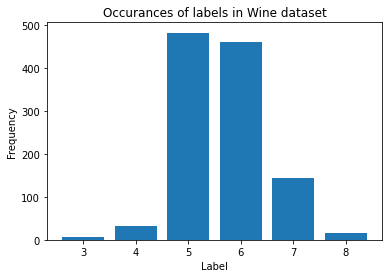

In [8]:
# plot a bar graph
dict_label = dict(dict_label)
plt.bar(list(dict_label.keys()),list(dict_label.values()))
plt.title('Occurances of labels in Wine dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

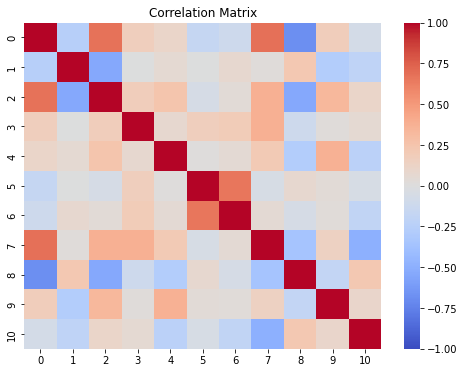

In [9]:
dataset = np.array(df)

np.random.shuffle(dataset)

"""
CHECK AGAIN BOOKMARK
"""

# Compute the correlation matrix using numpy
corr_matrix = np.corrcoef(dataset[:,:11], rowvar=False)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [10]:
X = dataset[:,:11]
y = dataset[:,11]

# standardize
# calc z score for each entry columnwise
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)

In [11]:
X.shape

(1143, 11)

In [12]:
# lets keep the split as train : 0.7, val : 0.1, test : 0.2
train_ratio = 0.65
val_ratio = 0.15
test_ratio = 0.20

In [13]:
entries = dataset.shape[0]

train_X = X[:int(train_ratio*entries)]
val_X = X[int(train_ratio*entries):int((train_ratio+val_ratio)*entries)]
test_X = X[int((train_ratio+val_ratio)*entries):]

In [14]:
train_y = y[:int(train_ratio*entries)]
val_y = y[int(train_ratio*entries):int((train_ratio+val_ratio)*entries)]
test_y = y[int((train_ratio+val_ratio)*entries):]

In [15]:
train_X.shape

(742, 11)

In [16]:
val_y.shape

(172,)

In [17]:
train_y.shape

(742,)

In [18]:
train_y = train_y.reshape((-1,1))

<br>

<h3>Model training and WandB tuning</h3>

In [19]:
print(np.unique(train_y))

[3. 4. 5. 6. 7. 8.]


In [20]:
import numpy as np
from sklearn.metrics import classification_report

# taken help from chat GPT

class MLPClassifier:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z))  # Stability trick to avoid overflow
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:  # If it's the last layer, apply softmax
                activations.append(self.softmax(Z))
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        correct_logprobs = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)])
        loss = np.sum(correct_logprobs) / m
        return loss

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                for i in range(X_train.shape[0]):
                    activations, Zs = self.forward_propagation(X_train[i:i+1])
                    grads = self.back_propagation(y_train[i:i+1], activations, Zs)
                    self.update_weights(grads)
            elif self.optimizer == 'bgd':
                activations, Zs = self.forward_propagation(X_train)
                grads = self.back_propagation(y_train, activations, Zs)
                self.update_weights(grads)
            elif self.optimizer == 'mbgd':
                batch_size = 32
                for i in range(0, X_train.shape[0], batch_size):
                    activations, Zs = self.forward_propagation(X_train[i:i+batch_size])
                    grads = self.back_propagation(y_train[i:i+batch_size], activations, Zs)
                    self.update_weights(grads)

            train_activations, _ = self.forward_propagation(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_accuracy = np.mean(np.argmax(train_activations[-1], axis=1) == np.argmax(y_train, axis=1))

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_accuracy = np.mean(np.argmax(val_activations[-1], axis=1) == np.argmax(y_val, axis=1))
                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f}")

            # wandb.log({
            #     "epoch": epoch,
            #     "train_loss": train_loss,
            #     "train_accuracy": train_accuracy,
            #     "val_loss": val_loss,
            #     "val_accuracy": val_accuracy
            # })

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)

    def inference(self, test_X, test_Y):
        y_pred = self.predict(test_X)
        y_true_labels = np.argmax(test_Y, axis=1)
        return classification_report(y_true_labels, y_pred)


In [21]:
import wandb

train_y = train_y.reshape((-1,1))
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_true = one_hot_encoder.fit_transform(train_y)

val_y = val_y.reshape((-1,1))
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_true_val = one_hot_encoder.fit_transform(val_y)

print(train_X.shape,y_true.shape,val_X.shape,y_true_val.shape)

(742, 11) (742, 6) (172, 11) (172, 6)


### Training on the dataset and reporting validation losses

In [22]:
mlp = MLPClassifier(learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[8, 6], epochs=1000)

# Train the model
mlp.fit(train_X,y_true,val_X,y_true_val)

# Make predictions
# y_pred = mlp.predict(X_test)

Epoch 1/1000 - train_loss: 1.2078 - train_accuracy: 0.4111 - val_loss: 1.1714 - val_accuracy: 0.4419
Epoch 2/1000 - train_loss: 1.1893 - train_accuracy: 0.4111 - val_loss: 1.1565 - val_accuracy: 0.4419
Epoch 3/1000 - train_loss: 1.1844 - train_accuracy: 0.4111 - val_loss: 1.1559 - val_accuracy: 0.4419
Epoch 4/1000 - train_loss: 1.1823 - train_accuracy: 0.4111 - val_loss: 1.1575 - val_accuracy: 0.4419
Epoch 5/1000 - train_loss: 1.1811 - train_accuracy: 0.4111 - val_loss: 1.1594 - val_accuracy: 0.4419
Epoch 6/1000 - train_loss: 1.1803 - train_accuracy: 0.4111 - val_loss: 1.1612 - val_accuracy: 0.4419
Epoch 7/1000 - train_loss: 1.1797 - train_accuracy: 0.4111 - val_loss: 1.1628 - val_accuracy: 0.4419
Epoch 8/1000 - train_loss: 1.1792 - train_accuracy: 0.4111 - val_loss: 1.1642 - val_accuracy: 0.4419
Epoch 9/1000 - train_loss: 1.1789 - train_accuracy: 0.4111 - val_loss: 1.1654 - val_accuracy: 0.4419
Epoch 10/1000 - train_loss: 1.1786 - train_accuracy: 0.4111 - val_loss: 1.1665 - val_accura

<h3>Classification report and Accuracy on Test Set</h3>

In [23]:
test_y = test_y.reshape((-1,1))
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_true_test = one_hot_encoder.fit_transform(test_y)

print(mlp.inference(test_X,y_true_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.17      0.22         6
           2       0.69      0.71      0.70       102
           3       0.49      0.59      0.53        85
           4       0.53      0.32      0.40        31
           5       0.00      0.00      0.00         3

    accuracy                           0.58       229
   macro avg       0.34      0.30      0.31       229
weighted avg       0.57      0.58      0.57       229



/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### WandB 

### Combinations of activation function and optimizers

In [24]:
import wandb
import numpy as np
from sklearn.metrics import accuracy_score

# Initialize W&B
wandb.init(project="mlp-new-2")

# Hyperparameters
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['sigmoid', 'tanh', 'relu']
optimzer = ['sgd','bgd','mbgd']

for lr in learning_rates:
    for activation in activation_functions:
        for optim in optimzer:
        # Set hyperparameters for this run
            config = {
                "learning_rate": lr,
                "activation_function": activation
            }

            # Create a new run for this hyperparameter set
            run = wandb.init(name=f'lr={lr}_act={activation}_optim={optim}',config=config,reinit=True)
            mlp = MLPClassifier(learning_rate=lr, activation=activation, optimizer=optim, hidden_layers=[8, 6],    epochs=100)
            mlp.fit(train_X,y_true,val_X,y_true_val)
        

        
            # End the run
            run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rohan-victorious108. Use `wandb login --relogin` to force relogin
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.5358 - train_accuracy: 0.4111 - val_loss: 1.5242 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.3962 - train_accuracy: 0.4111 - val_loss: 1.3767 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.3215 - train_accuracy: 0.4111 - val_loss: 1.2966 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.2793 - train_accuracy: 0.4111 - val_loss: 1.2508 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.2538 - train_accuracy: 0.4137 - val_loss: 1.2228 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.2373 - train_accuracy: 0.4137 - val_loss: 1.2048 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.2259 - train_accuracy: 0.4137 - val_loss: 1.1926 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.2178 - train_accuracy: 0.4137 - val_loss: 1.1839 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.2116 - train_accuracy: 0.4137 - val_loss: 1.1775 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.2068 - train_accuracy: 0.4137 - val_loss: 1.1728 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7873 - train_accuracy: 0.0013 - val_loss: 1.7869 - val_accuracy: 0.0174
Epoch 2/100 - train_loss: 1.7868 - train_accuracy: 0.4137 - val_loss: 1.7864 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7863 - train_accuracy: 0.4137 - val_loss: 1.7859 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7859 - train_accuracy: 0.4137 - val_loss: 1.7854 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7854 - train_accuracy: 0.4137 - val_loss: 1.7850 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7849 - train_accuracy: 0.4137 - val_loss: 1.7845 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7844 - train_accuracy: 0.4137 - val_loss: 1.7840 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7840 - train_accuracy: 0.4137 - val_loss: 1.7835 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7835 - train_accuracy: 0.4137 - val_loss: 1.7830 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7830 - train_accuracy: 0.4137 - val_loss: 1.7825 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7805 - train_accuracy: 0.4137 - val_loss: 1.7805 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7693 - train_accuracy: 0.4137 - val_loss: 1.7688 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7583 - train_accuracy: 0.4137 - val_loss: 1.7574 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7476 - train_accuracy: 0.4137 - val_loss: 1.7462 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7370 - train_accuracy: 0.4137 - val_loss: 1.7352 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7267 - train_accuracy: 0.4137 - val_loss: 1.7244 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7165 - train_accuracy: 0.4137 - val_loss: 1.7139 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7066 - train_accuracy: 0.4137 - val_loss: 1.7035 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.6969 - train_accuracy: 0.4137 - val_loss: 1.6934 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.6873 - train_accuracy: 0.4137 - val_loss: 1.6835 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.6667 - train_accuracy: 0.4137 - val_loss: 1.6617 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.5703 - train_accuracy: 0.4137 - val_loss: 1.5609 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.4965 - train_accuracy: 0.4137 - val_loss: 1.4833 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.4399 - train_accuracy: 0.4137 - val_loss: 1.4235 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.3963 - train_accuracy: 0.4137 - val_loss: 1.3771 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.3624 - train_accuracy: 0.4137 - val_loss: 1.3408 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.3357 - train_accuracy: 0.4137 - val_loss: 1.3121 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.3146 - train_accuracy: 0.4137 - val_loss: 1.2892 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.2975 - train_accuracy: 0.4137 - val_loss: 1.2707 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.2836 - train_accuracy: 0.4137 - val_loss: 1.2556 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7916 - train_accuracy: 0.3962 - val_loss: 1.7916 - val_accuracy: 0.3081
Epoch 2/100 - train_loss: 1.7914 - train_accuracy: 0.4003 - val_loss: 1.7914 - val_accuracy: 0.3547
Epoch 3/100 - train_loss: 1.7912 - train_accuracy: 0.4003 - val_loss: 1.7912 - val_accuracy: 0.3663
Epoch 4/100 - train_loss: 1.7910 - train_accuracy: 0.4030 - val_loss: 1.7910 - val_accuracy: 0.3837
Epoch 5/100 - train_loss: 1.7908 - train_accuracy: 0.3976 - val_loss: 1.7908 - val_accuracy: 0.3605
Epoch 6/100 - train_loss: 1.7906 - train_accuracy: 0.3935 - val_loss: 1.7906 - val_accuracy: 0.3779
Epoch 7/100 - train_loss: 1.7904 - train_accuracy: 0.3989 - val_loss: 1.7904 - val_accuracy: 0.3895
Epoch 8/100 - train_loss: 1.7902 - train_accuracy: 0.3962 - val_loss: 1.7902 - val_accuracy: 0.3953
Epoch 9/100 - train_loss: 1.7901 - train_accuracy: 0.4030 - val_loss: 1.7900 - val_accuracy: 0.3953
Epoch 10/100 - train_loss: 1.7899 - train_accuracy: 0.4070 - val_loss: 1.7898 - val_accuracy: 0.4012

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7872 - train_accuracy: 0.4137 - val_loss: 1.7870 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7826 - train_accuracy: 0.4137 - val_loss: 1.7822 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7781 - train_accuracy: 0.4137 - val_loss: 1.7775 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7736 - train_accuracy: 0.4137 - val_loss: 1.7729 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7691 - train_accuracy: 0.4137 - val_loss: 1.7682 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7647 - train_accuracy: 0.4137 - val_loss: 1.7636 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7603 - train_accuracy: 0.4137 - val_loss: 1.7591 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7560 - train_accuracy: 0.4137 - val_loss: 1.7546 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7516 - train_accuracy: 0.4137 - val_loss: 1.7501 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7474 - train_accuracy: 0.4137 - val_loss: 1.7456 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.6667 - train_accuracy: 0.4137 - val_loss: 1.6617 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.5704 - train_accuracy: 0.4137 - val_loss: 1.5609 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.4965 - train_accuracy: 0.4137 - val_loss: 1.4833 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.4400 - train_accuracy: 0.4137 - val_loss: 1.4235 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.3964 - train_accuracy: 0.4137 - val_loss: 1.3771 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.3624 - train_accuracy: 0.4137 - val_loss: 1.3409 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.3358 - train_accuracy: 0.4137 - val_loss: 1.3122 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.3146 - train_accuracy: 0.4137 - val_loss: 1.2893 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.2976 - train_accuracy: 0.4137 - val_loss: 1.2708 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.2837 - train_accuracy: 0.4137 - val_loss: 1.2557 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7916 - train_accuracy: 0.4124 - val_loss: 1.7916 - val_accuracy: 0.4535
Epoch 2/100 - train_loss: 1.7914 - train_accuracy: 0.3693 - val_loss: 1.7914 - val_accuracy: 0.4302
Epoch 3/100 - train_loss: 1.7912 - train_accuracy: 0.3774 - val_loss: 1.7912 - val_accuracy: 0.3895
Epoch 4/100 - train_loss: 1.7910 - train_accuracy: 0.3760 - val_loss: 1.7910 - val_accuracy: 0.4012
Epoch 5/100 - train_loss: 1.7908 - train_accuracy: 0.3827 - val_loss: 1.7908 - val_accuracy: 0.3895
Epoch 6/100 - train_loss: 1.7906 - train_accuracy: 0.3881 - val_loss: 1.7906 - val_accuracy: 0.4012
Epoch 7/100 - train_loss: 1.7904 - train_accuracy: 0.3854 - val_loss: 1.7904 - val_accuracy: 0.4128
Epoch 8/100 - train_loss: 1.7902 - train_accuracy: 0.3962 - val_loss: 1.7902 - val_accuracy: 0.3953
Epoch 9/100 - train_loss: 1.7900 - train_accuracy: 0.4016 - val_loss: 1.7900 - val_accuracy: 0.4128
Epoch 10/100 - train_loss: 1.7899 - train_accuracy: 0.3989 - val_loss: 1.7898 - val_accuracy: 0.4128

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7872 - train_accuracy: 0.4151 - val_loss: 1.7870 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7826 - train_accuracy: 0.4137 - val_loss: 1.7822 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7781 - train_accuracy: 0.4137 - val_loss: 1.7775 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7736 - train_accuracy: 0.4137 - val_loss: 1.7729 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7691 - train_accuracy: 0.4137 - val_loss: 1.7682 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7647 - train_accuracy: 0.4137 - val_loss: 1.7637 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7603 - train_accuracy: 0.4137 - val_loss: 1.7591 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7560 - train_accuracy: 0.4137 - val_loss: 1.7546 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7517 - train_accuracy: 0.4137 - val_loss: 1.7501 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7474 - train_accuracy: 0.4137 - val_loss: 1.7457 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.2082 - train_accuracy: 0.4111 - val_loss: 1.1715 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.1894 - train_accuracy: 0.4111 - val_loss: 1.1565 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.1845 - train_accuracy: 0.4111 - val_loss: 1.1560 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.1824 - train_accuracy: 0.4111 - val_loss: 1.1576 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.1812 - train_accuracy: 0.4111 - val_loss: 1.1595 - val_accuracy: 0.4419
Epoch 6/100 - train_loss: 1.1804 - train_accuracy: 0.4111 - val_loss: 1.1613 - val_accuracy: 0.4419
Epoch 7/100 - train_loss: 1.1798 - train_accuracy: 0.4111 - val_loss: 1.1629 - val_accuracy: 0.4419
Epoch 8/100 - train_loss: 1.1793 - train_accuracy: 0.4111 - val_loss: 1.1643 - val_accuracy: 0.4419
Epoch 9/100 - train_loss: 1.1790 - train_accuracy: 0.4111 - val_loss: 1.1655 - val_accuracy: 0.4419
Epoch 10/100 - train_loss: 1.1787 - train_accuracy: 0.4111 - val_loss: 1.1666 - val_accuracy: 0.4419

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7898 - train_accuracy: 0.4137 - val_loss: 1.7899 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7850 - train_accuracy: 0.4137 - val_loss: 1.7849 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7803 - train_accuracy: 0.4137 - val_loss: 1.7801 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7757 - train_accuracy: 0.4137 - val_loss: 1.7752 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7711 - train_accuracy: 0.4137 - val_loss: 1.7705 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7665 - train_accuracy: 0.4137 - val_loss: 1.7657 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7620 - train_accuracy: 0.4137 - val_loss: 1.7610 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7575 - train_accuracy: 0.4137 - val_loss: 1.7563 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7530 - train_accuracy: 0.4137 - val_loss: 1.7517 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7486 - train_accuracy: 0.4137 - val_loss: 1.7471 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.6838 - train_accuracy: 0.4111 - val_loss: 1.6793 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.5995 - train_accuracy: 0.4111 - val_loss: 1.5912 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.5312 - train_accuracy: 0.4137 - val_loss: 1.5196 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.4760 - train_accuracy: 0.4137 - val_loss: 1.4614 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.4313 - train_accuracy: 0.4137 - val_loss: 1.4140 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.3951 - train_accuracy: 0.4137 - val_loss: 1.3754 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.3656 - train_accuracy: 0.4137 - val_loss: 1.3437 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.3414 - train_accuracy: 0.4137 - val_loss: 1.3177 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.3215 - train_accuracy: 0.4137 - val_loss: 1.2962 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.3050 - train_accuracy: 0.4137 - val_loss: 1.2782 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.2834 - train_accuracy: 0.4111 - val_loss: 1.2549 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.2223 - train_accuracy: 0.4111 - val_loss: 1.1881 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.2036 - train_accuracy: 0.4111 - val_loss: 1.1692 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.1949 - train_accuracy: 0.4111 - val_loss: 1.1617 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.1901 - train_accuracy: 0.4111 - val_loss: 1.1584 - val_accuracy: 0.4419
Epoch 6/100 - train_loss: 1.1871 - train_accuracy: 0.4111 - val_loss: 1.1569 - val_accuracy: 0.4419
Epoch 7/100 - train_loss: 1.1851 - train_accuracy: 0.4111 - val_loss: 1.1565 - val_accuracy: 0.4419
Epoch 8/100 - train_loss: 1.1836 - train_accuracy: 0.4111 - val_loss: 1.1565 - val_accuracy: 0.4419
Epoch 9/100 - train_loss: 1.1825 - train_accuracy: 0.4111 - val_loss: 1.1568 - val_accuracy: 0.4419
Epoch 10/100 - train_loss: 1.1813 - train_accuracy: 0.4111 - val_loss: 1.1570 - val_accuracy: 0.4419

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7899 - train_accuracy: 0.4191 - val_loss: 1.7898 - val_accuracy: 0.4593
Epoch 2/100 - train_loss: 1.7880 - train_accuracy: 0.4151 - val_loss: 1.7878 - val_accuracy: 0.4128
Epoch 3/100 - train_loss: 1.7861 - train_accuracy: 0.4137 - val_loss: 1.7858 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7842 - train_accuracy: 0.4137 - val_loss: 1.7839 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7823 - train_accuracy: 0.4137 - val_loss: 1.7819 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7804 - train_accuracy: 0.4137 - val_loss: 1.7800 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7786 - train_accuracy: 0.4137 - val_loss: 1.7781 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7767 - train_accuracy: 0.4137 - val_loss: 1.7761 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7748 - train_accuracy: 0.4137 - val_loss: 1.7742 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7730 - train_accuracy: 0.4137 - val_loss: 1.7723 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7473 - train_accuracy: 0.4137 - val_loss: 1.7456 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7064 - train_accuracy: 0.4137 - val_loss: 1.7030 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.6688 - train_accuracy: 0.4137 - val_loss: 1.6638 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.6343 - train_accuracy: 0.4137 - val_loss: 1.6277 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.6026 - train_accuracy: 0.4137 - val_loss: 1.5946 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.5735 - train_accuracy: 0.4137 - val_loss: 1.5641 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.5469 - train_accuracy: 0.4137 - val_loss: 1.5361 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.5225 - train_accuracy: 0.4137 - val_loss: 1.5105 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.5001 - train_accuracy: 0.4137 - val_loss: 1.4869 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.4796 - train_accuracy: 0.4137 - val_loss: 1.4652 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.2835 - train_accuracy: 0.4111 - val_loss: 1.2550 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.2224 - train_accuracy: 0.4111 - val_loss: 1.1883 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.2038 - train_accuracy: 0.4111 - val_loss: 1.1694 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.1951 - train_accuracy: 0.4111 - val_loss: 1.1619 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.1903 - train_accuracy: 0.4111 - val_loss: 1.1585 - val_accuracy: 0.4419
Epoch 6/100 - train_loss: 1.1873 - train_accuracy: 0.4111 - val_loss: 1.1571 - val_accuracy: 0.4419
Epoch 7/100 - train_loss: 1.1853 - train_accuracy: 0.4111 - val_loss: 1.1566 - val_accuracy: 0.4419
Epoch 8/100 - train_loss: 1.1839 - train_accuracy: 0.4111 - val_loss: 1.1566 - val_accuracy: 0.4419
Epoch 9/100 - train_loss: 1.1828 - train_accuracy: 0.4111 - val_loss: 1.1570 - val_accuracy: 0.4419
Epoch 10/100 - train_loss: 1.1820 - train_accuracy: 0.4111 - val_loss: 1.1575 - val_accuracy: 0.4419

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7899 - train_accuracy: 0.4030 - val_loss: 1.7898 - val_accuracy: 0.4012
Epoch 2/100 - train_loss: 1.7880 - train_accuracy: 0.4137 - val_loss: 1.7878 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7861 - train_accuracy: 0.4137 - val_loss: 1.7858 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7842 - train_accuracy: 0.4137 - val_loss: 1.7839 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7823 - train_accuracy: 0.4137 - val_loss: 1.7819 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.7804 - train_accuracy: 0.4137 - val_loss: 1.7800 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.7786 - train_accuracy: 0.4137 - val_loss: 1.7781 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.7767 - train_accuracy: 0.4137 - val_loss: 1.7761 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.7748 - train_accuracy: 0.4137 - val_loss: 1.7742 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.7730 - train_accuracy: 0.4137 - val_loss: 1.7723 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7473 - train_accuracy: 0.4137 - val_loss: 1.7456 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7064 - train_accuracy: 0.4137 - val_loss: 1.7030 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.6688 - train_accuracy: 0.4137 - val_loss: 1.6637 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.6342 - train_accuracy: 0.4137 - val_loss: 1.6276 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.6025 - train_accuracy: 0.4137 - val_loss: 1.5945 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.5734 - train_accuracy: 0.4137 - val_loss: 1.5640 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.5467 - train_accuracy: 0.4137 - val_loss: 1.5360 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.5223 - train_accuracy: 0.4137 - val_loss: 1.5103 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.4999 - train_accuracy: 0.4137 - val_loss: 1.4867 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.4794 - train_accuracy: 0.4137 - val_loss: 1.4650 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.2055 - train_accuracy: 0.4111 - val_loss: 1.1769 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.1925 - train_accuracy: 0.4111 - val_loss: 1.1711 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.1045 - train_accuracy: 0.4960 - val_loss: 1.1011 - val_accuracy: 0.5349
Epoch 4/100 - train_loss: 0.9944 - train_accuracy: 0.5876 - val_loss: 1.0286 - val_accuracy: 0.5988
Epoch 5/100 - train_loss: 0.9678 - train_accuracy: 0.5970 - val_loss: 1.0191 - val_accuracy: 0.6047
Epoch 6/100 - train_loss: 0.9571 - train_accuracy: 0.5970 - val_loss: 1.0179 - val_accuracy: 0.6221
Epoch 7/100 - train_loss: 0.9515 - train_accuracy: 0.5997 - val_loss: 1.0181 - val_accuracy: 0.6221
Epoch 8/100 - train_loss: 0.9482 - train_accuracy: 0.5997 - val_loss: 1.0185 - val_accuracy: 0.6163
Epoch 9/100 - train_loss: 0.9459 - train_accuracy: 0.6065 - val_loss: 1.0192 - val_accuracy: 0.6163
Epoch 10/100 - train_loss: 0.9430 - train_accuracy: 0.6078 - val_loss: 1.0206 - val_accuracy: 0.6163

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7407 - train_accuracy: 0.4111 - val_loss: 1.7382 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.6982 - train_accuracy: 0.4111 - val_loss: 1.6940 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.6592 - train_accuracy: 0.4111 - val_loss: 1.6534 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.6236 - train_accuracy: 0.4111 - val_loss: 1.6162 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.5910 - train_accuracy: 0.4137 - val_loss: 1.5821 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.5612 - train_accuracy: 0.4137 - val_loss: 1.5509 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.5339 - train_accuracy: 0.4137 - val_loss: 1.5223 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.5090 - train_accuracy: 0.4137 - val_loss: 1.4961 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.4863 - train_accuracy: 0.4137 - val_loss: 1.4721 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.4655 - train_accuracy: 0.4137 - val_loss: 1.4501 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.3007 - train_accuracy: 0.4111 - val_loss: 1.2731 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.2287 - train_accuracy: 0.4111 - val_loss: 1.1935 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.2075 - train_accuracy: 0.4111 - val_loss: 1.1710 - val_accuracy: 0.4419
Epoch 4/100 - train_loss: 1.1976 - train_accuracy: 0.4111 - val_loss: 1.1619 - val_accuracy: 0.4419
Epoch 5/100 - train_loss: 1.1921 - train_accuracy: 0.4111 - val_loss: 1.1576 - val_accuracy: 0.4419
Epoch 6/100 - train_loss: 1.1887 - train_accuracy: 0.4111 - val_loss: 1.1557 - val_accuracy: 0.4419
Epoch 7/100 - train_loss: 1.1865 - train_accuracy: 0.4111 - val_loss: 1.1549 - val_accuracy: 0.4419
Epoch 8/100 - train_loss: 1.1849 - train_accuracy: 0.4111 - val_loss: 1.1547 - val_accuracy: 0.4419
Epoch 9/100 - train_loss: 1.1837 - train_accuracy: 0.4111 - val_loss: 1.1549 - val_accuracy: 0.4419
Epoch 10/100 - train_loss: 1.1828 - train_accuracy: 0.4111 - val_loss: 1.1553 - val_accuracy: 0.4419

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.1929 - train_accuracy: 0.4111 - val_loss: 1.1606 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.0011 - train_accuracy: 0.5701 - val_loss: 0.9806 - val_accuracy: 0.6105
Epoch 3/100 - train_loss: 0.9931 - train_accuracy: 0.5755 - val_loss: 0.9848 - val_accuracy: 0.6337
Epoch 4/100 - train_loss: 0.9715 - train_accuracy: 0.5930 - val_loss: 0.9949 - val_accuracy: 0.5988
Epoch 5/100 - train_loss: 0.9753 - train_accuracy: 0.5782 - val_loss: 0.9832 - val_accuracy: 0.6163
Epoch 6/100 - train_loss: 0.9887 - train_accuracy: 0.5863 - val_loss: 1.0188 - val_accuracy: 0.6047
Epoch 7/100 - train_loss: 0.9901 - train_accuracy: 0.5377 - val_loss: 1.0001 - val_accuracy: 0.5930
Epoch 8/100 - train_loss: 0.9774 - train_accuracy: 0.5849 - val_loss: 1.0117 - val_accuracy: 0.6105
Epoch 9/100 - train_loss: 0.9870 - train_accuracy: 0.5782 - val_loss: 1.0182 - val_accuracy: 0.6163
Epoch 10/100 - train_loss: 0.9908 - train_accuracy: 0.5121 - val_loss: 1.0134 - val_accuracy: 0.5523

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7728 - train_accuracy: 0.4151 - val_loss: 1.7721 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7546 - train_accuracy: 0.4137 - val_loss: 1.7531 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7369 - train_accuracy: 0.4137 - val_loss: 1.7348 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7198 - train_accuracy: 0.4137 - val_loss: 1.7170 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7033 - train_accuracy: 0.4137 - val_loss: 1.6998 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.6874 - train_accuracy: 0.4137 - val_loss: 1.6833 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.6721 - train_accuracy: 0.4137 - val_loss: 1.6672 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.6572 - train_accuracy: 0.4137 - val_loss: 1.6518 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.6429 - train_accuracy: 0.4137 - val_loss: 1.6368 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.6291 - train_accuracy: 0.4137 - val_loss: 1.6224 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.4773 - train_accuracy: 0.4137 - val_loss: 1.4628 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.3450 - train_accuracy: 0.4137 - val_loss: 1.3216 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.2847 - train_accuracy: 0.4137 - val_loss: 1.2560 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.2534 - train_accuracy: 0.4137 - val_loss: 1.2215 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.2352 - train_accuracy: 0.4137 - val_loss: 1.2015 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.2234 - train_accuracy: 0.4137 - val_loss: 1.1887 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.2153 - train_accuracy: 0.4137 - val_loss: 1.1801 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.2093 - train_accuracy: 0.4137 - val_loss: 1.1740 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.2048 - train_accuracy: 0.4137 - val_loss: 1.1695 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.2012 - train_accuracy: 0.4137 - val_loss: 1.1662 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.1931 - train_accuracy: 0.4111 - val_loss: 1.1607 - val_accuracy: 0.4419
Epoch 2/100 - train_loss: 1.1897 - train_accuracy: 0.4111 - val_loss: 1.1665 - val_accuracy: 0.4419
Epoch 3/100 - train_loss: 1.0915 - train_accuracy: 0.5243 - val_loss: 1.0736 - val_accuracy: 0.5581
Epoch 4/100 - train_loss: 1.0253 - train_accuracy: 0.5741 - val_loss: 1.0365 - val_accuracy: 0.6163
Epoch 5/100 - train_loss: 1.0565 - train_accuracy: 0.5337 - val_loss: 1.0564 - val_accuracy: 0.5698
Epoch 6/100 - train_loss: 1.0251 - train_accuracy: 0.5903 - val_loss: 1.0339 - val_accuracy: 0.5988
Epoch 7/100 - train_loss: 1.0564 - train_accuracy: 0.5566 - val_loss: 1.0618 - val_accuracy: 0.5988
Epoch 8/100 - train_loss: 1.0068 - train_accuracy: 0.5997 - val_loss: 1.0434 - val_accuracy: 0.5930
Epoch 9/100 - train_loss: 1.0361 - train_accuracy: 0.5889 - val_loss: 1.0570 - val_accuracy: 0.5930
Epoch 10/100 - train_loss: 1.0377 - train_accuracy: 0.5957 - val_loss: 1.0576 - val_accuracy: 0.5988

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.7729 - train_accuracy: 0.4137 - val_loss: 1.7721 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.7546 - train_accuracy: 0.4137 - val_loss: 1.7532 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.7369 - train_accuracy: 0.4137 - val_loss: 1.7348 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.7199 - train_accuracy: 0.4137 - val_loss: 1.7171 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.7034 - train_accuracy: 0.4137 - val_loss: 1.6999 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.6875 - train_accuracy: 0.4137 - val_loss: 1.6833 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.6721 - train_accuracy: 0.4137 - val_loss: 1.6673 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.6573 - train_accuracy: 0.4137 - val_loss: 1.6519 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.6430 - train_accuracy: 0.4137 - val_loss: 1.6369 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.6292 - train_accuracy: 0.4137 - val_loss: 1.6225 - val_accuracy: 0.4070

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/100 - train_loss: 1.4774 - train_accuracy: 0.4137 - val_loss: 1.4628 - val_accuracy: 0.4070
Epoch 2/100 - train_loss: 1.3451 - train_accuracy: 0.4137 - val_loss: 1.3217 - val_accuracy: 0.4070
Epoch 3/100 - train_loss: 1.2848 - train_accuracy: 0.4137 - val_loss: 1.2561 - val_accuracy: 0.4070
Epoch 4/100 - train_loss: 1.2536 - train_accuracy: 0.4137 - val_loss: 1.2217 - val_accuracy: 0.4070
Epoch 5/100 - train_loss: 1.2353 - train_accuracy: 0.4137 - val_loss: 1.2017 - val_accuracy: 0.4070
Epoch 6/100 - train_loss: 1.2236 - train_accuracy: 0.4137 - val_loss: 1.1890 - val_accuracy: 0.4070
Epoch 7/100 - train_loss: 1.2155 - train_accuracy: 0.4137 - val_loss: 1.1803 - val_accuracy: 0.4070
Epoch 8/100 - train_loss: 1.2095 - train_accuracy: 0.4137 - val_loss: 1.1742 - val_accuracy: 0.4070
Epoch 9/100 - train_loss: 1.2050 - train_accuracy: 0.4137 - val_loss: 1.1698 - val_accuracy: 0.4070
Epoch 10/100 - train_loss: 1.2014 - train_accuracy: 0.4137 - val_loss: 1.1664 - val_accuracy: 0.4070

### Multilabel classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import LabelPowerset

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('./advertisement.csv')

In [3]:
np_ds = np.array(df)

In [4]:
unique_labels  = set()

for arr in np_ds:
    lbl_str = arr[-1].split(' ')
    for lbl in lbl_str:
        unique_labels.add(lbl)

print(unique_labels)

{'sports', 'clothing', 'electronics', 'food', 'books', 'furniture', 'beauty', 'home'}


In [5]:
df[df["gender"]=="Female"].head(50)

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home
5,20,Female,51266.767047,Master,True,3,Frankport,Scientist,95.145103,laptop,sports electronics books
7,20,Female,35325.309005,PhD,False,3,South Raventown,Housewife,110.564517,dictionary,books beauty
10,57,Female,60907.844629,PhD,True,0,Gutierrezborough,HR,78.831675,shoes,clothing home
11,27,Female,51033.627935,PhD,True,2,Lake Tiffanyhaven,Scientist,138.672618,maggi,food books
13,44,Female,34683.652618,Master,True,2,West Darlenemouth,Engineer,89.101465,bat,sports furniture food home
14,51,Female,48815.172160,Bachelor,False,0,New Anthonytown,Salesman,65.797622,biscuits,beauty clothing food
15,42,Female,40527.463149,High School,False,2,Markfurt,Engineer,101.597316,gloves,books clothing sports


In [6]:
female_df = df[df["gender"]=="Female"]

In [7]:
np_ds_female = np.array(female_df)

map_labels1 = {}

for arr in np_ds_female:
    lbl_str = arr[-1].split(' ')
    for lbl in lbl_str:
        try:
            map_labels1[lbl]+=1
        except:
            map_labels1[lbl]=1

print(map_labels1)

{'furniture': 179, 'beauty': 183, 'clothing': 162, 'electronics': 147, 'food': 173, 'sports': 183, 'home': 172, 'books': 177}


In [8]:
np_ds_female.shape

(506, 11)

In [9]:
print(sum(list(map_labels1.values())))

1376


In [10]:
male_df = df[df["gender"]=="Male"]

In [11]:
np_ds_male = np.array(male_df)

map_labels2 = {}

for arr in np_ds_male:
    lbl_str = arr[-1].split(' ')
    for lbl in lbl_str:
        try:
            map_labels2[lbl]+=1
        except:
            map_labels2[lbl]=1

print(map_labels2)

{'electronics': 185, 'clothing': 172, 'sports': 179, 'food': 170, 'beauty': 173, 'furniture': 157, 'home': 168, 'books': 178}


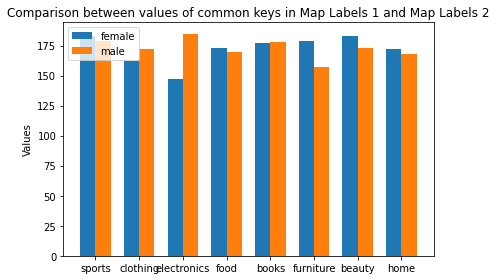

In [12]:

# Find common keys
common_keys = set(map_labels1.keys()) & set(map_labels2.keys())

# Prepare data for plotting
values1 = [map_labels1[key] for key in common_keys]
values2 = [map_labels2[key] for key in common_keys]

# Plotting
import matplotlib.pyplot as plt
import numpy as np

# Setting up the x-axis positions
x = np.arange(len(common_keys))

# Setting up the width for bars
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values1, width, label='female')
rects2 = ax.bar(x + width/2, values2, width, label='male')

# Adding labels, title, and legend
ax.set_ylabel('Values')
ax.set_title('Comparison between values of common keys in Map Labels 1 and Map Labels 2')
ax.set_xticks(x)
ax.set_xticklabels(common_keys)
ax.legend()

fig.tight_layout()
plt.show()

In [13]:
# Splitting  the train val test split
# keeping the ration 70 : 15 : 15
test = 0.10
val = 0.15
train = 0.80

df = pd.read_csv('./advertisement.csv')
data = np.array(df)

In [14]:
"""
We can see column : 1,3,4,6,7,9 are categorical , hence need to be encoded.
"""

for column in [1,3,4,6,7,9]:
    label_encode = LabelEncoder()
    encoded_feature = label_encode.fit_transform(data[:,column])
    data[:,column] = encoded_feature

In [15]:
print(data.shape)

(1000, 11)


In [16]:
print(data[:,:-1])

[[45 1 61271.953358890096 ... 2 87.69711834242366 16]
 [24 0 53229.101073561775 ... 1 115.13558622549095 13]
 [45 0 30066.04668359846 ... 3 101.69455857438264 3]
 ...
 [64 0 68740.44200637276 ... 8 101.4346500112247 1]
 [18 0 44348.44667993933 ... 7 97.64998780156692 19]
 [61 1 39160.08367652033 ... 5 105.59148548653422 20]]


In [17]:
my_featur_sample = data[:,:-1].copy() 
my_featur_sample  = my_featur_sample.astype(np.float64)

In [18]:
my_featur_sample = (my_featur_sample - np.mean(my_featur_sample,axis=0))/(np.std(my_featur_sample,axis=0))

In [19]:
np.std(np.array([[1],[2],[3]]),axis=1)

array([0., 0., 0.])

In [20]:
print(data[0])

[45 1 61271.953358890096 2 0 3 366 2 87.69711834242366 16
 'electronics clothing sports']


In [21]:
data[:,:-1] = my_featur_sample

In [22]:
label_encode_mlb = MultiLabelBinarizer()

formatted_list = []

for lbl_string in data[:,-1]:
    formatted_list.append(lbl_string.split(' '))
    
encoded_labels = label_encode_mlb.fit_transform(formatted_list)
    
train_x,train_y = data[:int(train*data.shape[0]),:-1],encoded_labels[:int(train*data.shape[0])]
val_x,val_y = data[int(train*data.shape[0]):int(train*data.shape[0])+int(val*data.shape[0]),:-1],encoded_labels[int(train*data.shape[0]):int(train*data.shape[0])+int(val*data.shape[0])]
test_x,test_y = data[int(train*data.shape[0])+int(val*data.shape[0]):int(train*data.shape[0])+int(val*data.shape[0])+int(test*data.shape[0]),:-1],encoded_labels[int(train*data.shape[0])+int(val*data.shape[0]):int(train*data.shape[0])+int(val*data.shape[0])+int(test*data.shape[0])]

print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)
print(val_x.shape,val_y.shape)

(800, 10) (800, 8)
(50, 10) (50, 8)
(150, 10) (150, 8)


In [23]:
label_encode.classes_

array(['ball', 'bat', 'bed', 'biscuits', 'carpet', 'chair', 'chips',
       'cream', 'curtains', 'dictionary', 'encyclopedia', 'gloves',
       'laptop', 'lipstick', 'maggi', 'mobile', 'monitor', 'novel',
       'pants', 'perfume', 'shirt', 'shoes', 'sofa', 'table'],
      dtype=object)

In [24]:
print(train_y.shape)
print(train_x.shape)

(800, 8)
(800, 10)


In [25]:
print(train_x)

[[0.3021780994086131 1.0120728718702643 1.2055331632498885 ...
  -0.97278093031368 -0.6588987724783364 0.6479072726304642]
 [-1.2217748514993776 -0.9880711436836177 0.39226380262719973 ...
  -1.2875967653666507 0.6901873453247652 0.21548862571358032]
 [0.3021780994086131 -0.9880711436836177 -1.9499155344417818 ...
  -0.657965095260709 0.029323047420286356 -1.2259068640093658]
 ...
 [-1.0040672870839504 -0.9880711436836177 -0.1949772876203305 ...
  0.2864824098982035 0.21119436800313393 1.6568841154365266]
 [-1.3669132277763292 1.0120728718702643 0.009224830104372281 ...
  0.2864824098982035 1.151382853576948 1.6568841154365266]
 [0.8827316045164192 -0.9880711436836177 -2.2453989253520885 ...
  -1.6024126004196217 2.136759555367617 0.9361863705750534]]


In [26]:
import numpy as np
from sklearn.metrics import classification_report

# taken help from chatgpt

"""
Method of finding accuracy : 
- Though logically not that correct, due to accuracy constraints I used the hamming loss method indirectly, 
to calculate accuracy. 
"""

class MLPClassifier_multilabel:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:  # If it's the last layer, apply sigmoid for multilabel
                activations.append(self._sigmoid(Z))
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        logprobs = np.multiply(np.log(y_pred), y_true) + np.multiply(np.log(1 - y_pred), (1 - y_true))
        loss = - np.sum(logprobs) / m
        return loss

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                for i in range(X_train.shape[0]):
                    activations, Zs = self.forward_propagation(X_train[i:i+1])
                    grads = self.back_propagation(y_train[i:i+1], activations, Zs)
                    self.update_weights(grads)
            elif self.optimizer == 'bgd':
                activations, Zs = self.forward_propagation(X_train)
                grads = self.back_propagation(y_train, activations, Zs)
                self.update_weights(grads)
            elif self.optimizer == 'mbgd':
                batch_size = 32
                for i in range(0, X_train.shape[0], batch_size):
                    activations, Zs = self.forward_propagation(X_train[i:i+batch_size])
                    grads = self.back_propagation(y_train[i:i+batch_size], activations, Zs)
                    self.update_weights(grads)

            train_activations, _ = self.forward_propagation(X_train)
            print(train_activations[-1].shape,y_train.shape)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_accuracy = np.mean((train_activations[-1] >= 0.5) == y_train)

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_accuracy = np.mean((val_activations[-1] > 0.5) == y_val)
                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f}")

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return (activations[-1] > 0.5).astype(int)

    def inference(self, test_X, test_Y):
        y_pred = self.predict(test_X)
        # y_true_labels = np.argmax(test_Y, axis=1)
        return np.mean(y_pred==test_Y)

In [27]:
mlp = MLPClassifier_multilabel(learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[8, 6], epochs=1000)

# Train the model
mlp.fit(train_x.astype(np.float64),train_y.astype(np.float64),val_x.astype(np.float64),val_y.astype(np.float64))

(800, 8) (800, 8)
Epoch 1/1000 - train_loss: 5.1449 - train_accuracy: 0.6573 - val_loss: 5.2032 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 2/1000 - train_loss: 5.1448 - train_accuracy: 0.6573 - val_loss: 5.2037 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 3/1000 - train_loss: 5.1447 - train_accuracy: 0.6573 - val_loss: 5.2037 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 4/1000 - train_loss: 5.1446 - train_accuracy: 0.6573 - val_loss: 5.2037 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 5/1000 - train_loss: 5.1445 - train_accuracy: 0.6573 - val_loss: 5.2037 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 6/1000 - train_loss: 5.1444 - train_accuracy: 0.6573 - val_loss: 5.2037 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 7/1000 - train_loss: 5.1443 - train_accuracy: 0.6573 - val_loss: 5.2038 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 8/1000 - train_loss: 5.1442 - train_accuracy: 0.6573 - val_loss: 5.2038 - val_accuracy: 0.6433
(800, 8) (800, 8)
Epoch 9/1000 - train_loss: 5.1

### Test Report for multilabel classification

In [28]:
print(test_x.shape,test_y.shape)

(50, 10) (50, 8)


In [29]:
print("Accuracy = ",mlp.inference(test_x.astype(np.float64),test_y.astype(np.float64)))

Accuracy =  0.6475
